In [1]:
import keras

In [2]:
keras.__version__

'0.3.2'

In [3]:
from __future__ import absolute_import, division, print_function
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.core import (
    Activation, Dense, Dropout, Flatten,
    Permute, Reshape, TimeDistributedDense
)
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.recurrent import GRU
from keras.regularizers import l1, l2, l1l2
from keras.utils import np_utils
from keras import backend as K
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import time
import re
import numpy as np
from collections import OrderedDict
from sklearn.metrics import auc, log_loss, precision_recall_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 82.0% of memory, cuDNN 5005)
/home/alvin/Dropbox/Lab/CNN/deeplift/env/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
HepG2_dna = "/home/alvin/Dropbox/Lab/CNN/data/processed_cnn/HepG2_dna.txt"
HepG2_tarcat = "/home/alvin/Dropbox/Lab/CNN/data/processed_cnn/HepG2_tar_cat.txt"
HepG2_tarbin = "/home/alvin/Dropbox/Lab/CNN/data/processed_cnn/HepG2_tar_bin.txt"
HepG2_tarraw = "/home/alvin/Dropbox/Lab/CNN/data/processed_cnn/HepG2_tar_raw.txt"
K562_dna = "/home/alvin/Dropbox/Lab/CNN/data/processed_cnn/K562_dna.txt"
K562_tarcat = "/home/alvin/Dropbox/Lab/CNN/data/processed_cnn/K562_tar_cat.txt"
K562_tarbin = "/home/alvin/Dropbox/Lab/CNN/data/processed_cnn/K562_tar_bin.txt"
K562_tarraw = "/home/alvin/Dropbox/Lab/CNN/data/processed_cnn/K562_tar_raw.txt"

In [5]:
%matplotlib inline
import seaborn as sns; sns.set(style="white", color_codes=True)
from scipy.stats.mstats import zscore

In [33]:
import hepg2_k562_cat
reload(hepg2_k562_cat)

<module 'hepg2_k562_cat' from 'hepg2_k562_cat.pyc'>

In [27]:
k562_initalObj = hepg2_k562_cat.Initalizer(K562_dna, K562_tarbin, "k562")

In [28]:
k562_initalObj.prepare()

Illegal line at 1948495
Preparation of input matrices complete


In [29]:
k562X_train, k562X_test, k562Y_train, k562Y_test = k562_initalObj.return_test_train_2class()

In [30]:
k562neg_weights, k562pos_weights = k562_initalObj.get_weight_2class(k562Y_train)

In [34]:
k562_binmodel = hepg2_k562_cat.BinaryModel(verbose = 1, seq_length = 145, name = "k562_binmodel")
k562_binmodel.model2()

In [35]:
k562_binmodel.model.fit(k562X_train, k562Y_train, batch_size = 7500, nb_epoch = 30, class_weight = {0:k562neg_weights, 1:1.5*k562pos_weights}
                         ,validation_data = (k562X_test, k562Y_test))

Train on 389700 samples, validate on 97425 samples
Epoch 1/30
389700/389700 [==============================] - 9s - loss: 7.7480 - val_loss: 0.7655
Epoch 2/30
389700/389700 [==============================] - 9s - loss: 5.9864 - val_loss: 0.7537
Epoch 3/30
389700/389700 [==============================] - 9s - loss: 4.7947 - val_loss: 0.7296
Epoch 4/30
389700/389700 [==============================] - 9s - loss: 3.9080 - val_loss: 0.7464
Epoch 5/30
389700/389700 [==============================] - 9s - loss: 3.2641 - val_loss: 0.7465
Epoch 6/30
389700/389700 [==============================] - 9s - loss: 2.8096 - val_loss: 0.7643
Epoch 7/30
389700/389700 [==============================] - 9s - loss: 2.4909 - val_loss: 0.7423
Epoch 8/30
389700/389700 [==============================] - 9s - loss: 2.2667 - val_loss: 0.8205
Epoch 9/30
389700/389700 [==============================] - 9s - loss: 2.0983 - val_loss: 0.7326
Epoch 10/30
389700/389700 [==============================] - 9s - loss: 1.97

In [36]:
k562_class_result = k562_binmodel.test(k562X_test, k562Y_test)

97425/97425 [==============================] - 1s     


In [37]:
k562_class_result.binary(k562_class_result.labels.astype(bool),k562_class_result.flat_predictions)

[('Loss', 0.71687894513200323),
 ('Balanced_accuracy', 60.123666314461154),
 ('auROC', 0.65025359225471058),
 ('auPRC', 0.47097405903092793),
 ('auPRG', 0.34821346047473561),
 ('Recall_at_5%_FDR', 0.0),
 ('Recall_at_10%_FDR', 0.0),
 ('Recall_at_20%_FDR', 0.0),
 ('Num_Positives', 36165),
 ('Num_Negatives', 61260)]

In [38]:
import deeplift
from deeplift.conversion import keras_conversion as kc

In [49]:
deeplift_model = kc.convert_sequential_model(
                    k562_binmodel.model,
                    nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode .DeepLIFT)

In [46]:
from deeplift import backend as B

In [50]:
find_scores_layer_idx = 0

In [52]:
deeplift_contribs_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx=find_scores_layer_idx,
                            target_layer_idx=-2)

In [53]:
scores = np.array(deeplift_contribs_func(task_idx=0,
                                         input_data_list=[k562X_test],
                                         batch_size=100,
                                         progress_update=1000))

No reference provided - using zeros
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Done 13000
Done 14000
Done 15000
Done 16000
Done 17000
Done 18000
Done 19000
Done 20000
Done 21000
Done 22000
Done 23000
Done 24000
Done 25000
Done 26000
Done 27000
Done 28000
Done 29000
Done 30000
Done 31000
Done 32000
Done 33000
Done 34000
Done 35000
Done 36000
Done 37000
Done 38000
Done 39000
Done 40000
Done 41000
Done 42000
Done 43000
Done 44000
Done 45000
Done 46000
Done 47000
Done 48000
Done 49000
Done 50000
Done 51000
Done 52000
Done 53000
Done 54000
Done 55000
Done 56000
Done 57000
Done 58000
Done 59000
Done 60000
Done 61000
Done 62000
Done 63000
Done 64000
Done 65000
Done 66000
Done 67000
Done 68000
Done 69000
Done 70000
Done 71000
Done 72000
Done 73000
Done 74000
Done 75000
Done 76000
Done 77000
Done 78000
Done 79000
Done 80000
Done 81000
Done 82000
Done 83000
Done 84000
Done 85000
Done 86000
Done 87000
Done 8800

In [56]:
scores.shape

(97425, 1, 4, 145)

In [57]:
scores2 = np.squeeze(np.sum(scores, axis=2),axis=1)

In [59]:
scores2.shape

(97425, 145)

In [63]:
scores

array([[[[-0.00118646, -0.        , -0.01579052, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.0091572 ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [-0.        , -0.        , -0.        , ...,  0.        ,
           0.        ,  0.        ]]],


       [[[-0.        , -0.        , -0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        , -0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.02066914,  0.01522873, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.00605271, -0.        , -0.        , ...,  0.        ,
           0.        ,  0.        ]]],


       [[[-0.        , -0.        , -0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0

In [60]:
from deeplift.visualization import viz_sequence
reload(viz_sequence)

<module 'deeplift.visualization.viz_sequence' from '/home/alvin/Dropbox/Lab/CNN/deeplift/deeplift/deeplift/visualization/viz_sequence.pyc'>

In [65]:
test_plot = k562X_test[0]*scores[0]

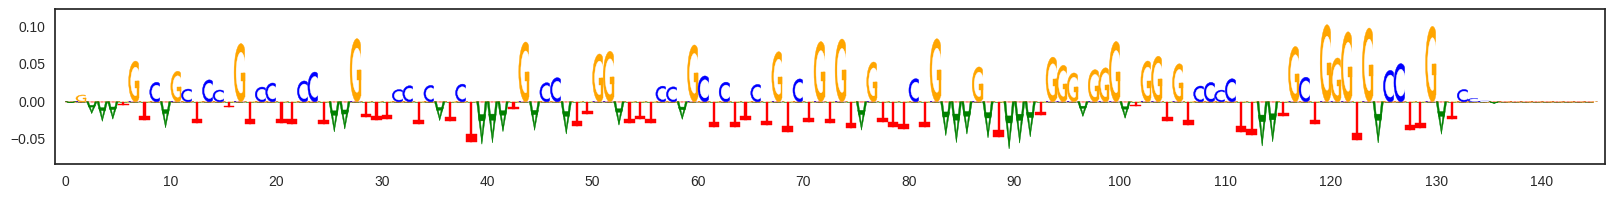

In [67]:
viz_sequence.plot_weights(test_plot, subticks_frequency=10)